## Setup and login
- Define the database backend. Local json files is the default.
- Inititize FetchJson
- login, Make sure to have a config.ini configured

In [1]:
from fetch import FetchJson
from ZFileDb import ZFileDb

# Define the database
db = ZFileDb(db_path="/Volumes/GoogleDrive/My Drive/ZWIFT/DATABASE/ZFileDb")
z = FetchJson(db=db)
z.login()

## Get event result and plot
- All API reusts are cached into local TinyDB database by default.
- The api data is not proccessed.
- If multiple APIs are present they are combined

In [7]:
result, status = z.fetch_result(zid=2552316)
print(f"Cache or refresh: {status}")
print(f"Event ID, 'zid' is: {result['zid']}")
print(f"Top level data in JSON: {result.keys()}")
print("Top five")
for racer in result['zwift_data'][:5]:
    if int(racer['pos']) <=5:
        print(f"{racer['pos']}: {racer['name']} with a time of {racer['race_time'][0]}")

Cache or refresh: cache
Event ID, 'zid' is: 2552316
Top level data in JSON: dict_keys(['zid', 'timestamp', 'view_data', 'zwift_data'])
Top five
1: Seigo. Ito[TKB] with a time of 4894.206
2: Alexander Bojsen [ACR] with a time of 4896.972
3: Nicolas  Rou  with a time of 4897.824
4: Oscar Feldfos with a time of 4898.2
5: Anders Broberg[SZ](UMARA) with a time of 4898.256


##Getting started with analysis
- Tools for this will be added in the future
- Many columns are a list of two values with the second=0 use splitlist()
- Many integer columns have blank "" values that mayb better be 0

In [8]:
import pandas as pd
df = pd.DataFrame(result['zwift_data'])

def splitlist(df, col, drop2=True):
    df[[f'{col}', f'{col}_2' ]] = df[col].tolist()
    if drop2:
        df.drop(f'{col}_2', axis=1, inplace=True)

splitlist(df, 'watts')
splitlist(df, 'wkg')
splitlist(df, 'wkg_ftp')

df.head()

,DT_RowId,name,watts,wkg,bpm,hrm,race_time,time_diff,zwid,label,dq_cat,pos,power_type,wkg_ftp,wkg1200,lagp,events
0,270093,Seigo. Ito[TKB],240,4.07,"[131, 0]",1,"[4894.206, 1]",0.000,270093,1,,1,3,4.15,"[0, 0]",,
1,131584,Alexander Bojsen [ACR],300,3.84,"[149, 0]",1,"[4896.972, 0]",2.766,131584,1,,2,3,3.92,"[0, 0]",,
2,845655,Nicolas Rou,288,4.06,"[169, 0]",1,"[4897.824, 0]",3.618,845655,1,,3,3,4.14,"[0, 0]",,
3,2818577,Oscar Feldfos,226,4.01,"[169, 0]",1,"[4898.2, 0]",3.994,2818577,1,,4,3,4.10,"[0, 0]",,
4,407765,Anders Broberg[SZ](UMARA),310,3.88,"[140, 0]",1,"[4898.256, 0]",4.050,407765,1,,5,3,3.96,"[0, 0]",,


In [9]:
df[['watts', 'wkg', 'wkg_ftp']] = df[['watts', 'wkg', 'wkg_ftp']].astype(float)

<AxesSubplot:>

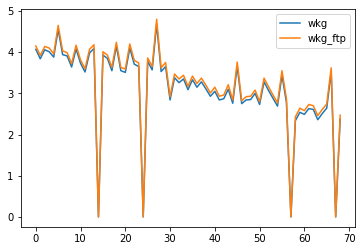

In [10]:
df[['wkg', 'wkg_ftp']].plot()

In [210]:
%load_ext autoreload
%autoreload 2
from fetch import FetchJson
from ZFileDb import ZFileDb
# Define the database
db = ZFileDb(db_path="/Volumes/GoogleDrive/My Drive/ZWIFT/DATABASE/ZFileDb")
z = FetchJson(db=db)
z.login()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
from time import sleep
team_id = 11991
triders, status = z.fetch_team(zid = team_id)
count = 0
for r in triders['team']:
    # print(r)
    p = z.fetch_profile(r['zwid'], profile_ext=True, refresh=True)
    print(f"Riders count: {count}")
    count += 1
    if p is not None:
        # print(f"Rider id:{p['zid']}")
        pass
    else:
        print(f"None from rider id: {r['zwid']}")
    sleep(1)

Riders count: 0
Riders count: 1
Riders count: 2
Riders count: 3
Riders count: 4
Riders count: 5
Riders count: 6
Riders count: 7
Riders count: 8
Riders count: 9
Riders count: 10
Riders count: 11
Riders count: 12
Riders count: 13
Riders count: 14
Riders count: 15
Riders count: 16


KeyboardInterrupt: 

In [198]:
import pandas as pd
def splitlist(df, col, drop2=True):
        df[[f'{col}', f'{col}_2' ]] = df[col].tolist()
        if drop2:
            df.drop(f'{col}_2', axis=1, inplace=True)

def weight_stats(zid):
    stats = {}
    try:
        profile = z.fetch_profile(zid, profile_ext=True)['pall']
        dz = pd.DataFrame(profile)
        splitlist(dz, 'weight')
        dz = dz[dz.event_date >= 1609484400]
        dz.sort_values('event_date', inplace=True)
        dz.reset_index(drop=True, inplace=True)
        dz['change'] = (dz['weight'] != dz['weight'].shift(1))
        stats['zid'] = zid
        stats['start21'] = float(dz.weight.iloc[0])
        stats['now'] = float(dz.weight.iloc[-1])
        stats['max'] = float(dz.weight.max())
        stats['min'] = float(dz.weight.min())
        stats['count'] = float(dz.weight.nunique())
        stats['mid_point'] = (stats['max'] + stats['min'])/2
        stats['scaled_max'] = stats['max']/stats['mid_point']
        stats['scaled_min'] = stats['min']/stats['mid_point']
        stats['scaled_now'] = stats['now']/stats['mid_point']
        stats["name"] = dz['name'].iloc[0]
        stats['url'] = f"https://zwiftpower.com/profile.php?z={zid}"
        stats['event_count'] = dz.distance.count()
        stats['change_count'] = dz['change'].sum()
        stats['change_ratio'] = stats['change_count'] / stats['event_count']
        # print(stats)
        return stats, None, dz
    except:
        return None, zid, dz
        raise
        print(stats)
        print(zid)

team_id = 11991
triders, status = z.fetch_team(zid = team_id)

team_weight_stats = []
bad_list = []
for r in triders['team']:
    # print(r)
    stat, bad, dz= weight_stats(r['zwid'])
    if stat:
        team_weight_stats.append(stat)
    elif bad:
        bad_list.append({'zid': bad, 'url':f"https://zwiftpower.com/profile.php?z={bad}"})

team_weight_stats_pd = pd.DataFrame(team_weight_stats)
team_weight_stats_pd.to_excel('team_weight_stats_2.xlsx')
bad_list_pd = pd.DataFrame(bad_list)
bad_list_pd.to_excel('bad_list_2.xlsx')

In [191]:
import pandas as pd
def splitlist(df, col, drop2=True):
        df[[f'{col}', f'{col}_2' ]] = df[col].tolist()
        if drop2:
            df.drop(f'{col}_2', axis=1, inplace=True)


In [192]:
dz

,DT_RowId,ftp,friend,pt,label,zid,pos,position_in_cat,name,cp,...,info_notes,strike,event_title,f_t,distance,event_date,rt,laps,dur,change
0,,272,0,,2,2278490,14,8,Alejandro 1559 [COALITION],0,...,[],-1,ZHQ FutureWorks Crit City Race - Anti-sandbagging,TYPE_RACE TYPE_RACE,20,1631190600,947394567,10,,2
1,,272,0,,2,2287138,7,2,Alejandro 1559 [COALITION],0,...,[],-1,Dream Bike Race Series,TYPE_RACE TYPE_RACE,27,1631723400,2737483381,3,,2
2,,272,0,,2,2288680,15,2,Alejandro 1559 [COALITION],0,...,[],-1,OTAKAM Race Series,TYPE_RACE TYPE_RACE,29,1631809800,982239385,2,,2
3,,272,0,,2,2295800,79,46,Alejandro 1559 [COALITION],0,...,[],-1,WTRL Racing,TYPE_RACE TYPE_RACE,28,1632241800,1064303857,1,,2
4,,272,0,,2,2297379,9,7,Alejandro 1559 [COALITION],0,...,[],-1,ZHQ FutureWorks Circuit Race - Anti-sandbagging,TYPE_RACE TYPE_RACE,23,1632317400,3364574135,3,,2
5,,272,0,,2,2299016,16,3,Alejandro 1559 [COALITION],0,...,[],-1,"Team KST ""King and Queen of Crits"" Race",TYPE_RACE TYPE_RACE,20,1632420000,2875658892,10,,2
6,,272,0,,2,2309380,42,42,Alejandro 1559 [COALITION],0,...,[],-1,Zwift Racing League | WTRL - Mixed/Mens EMEA E...,TYPE_RACE,28,1632848640,1064303857,1,,2
7,,272,0,,2,2311384,39,18,Alejandro 1559 [COALITION],0,...,[],-1,Crit City Race,TYPE_RACE TYPE_RACE,24,1633016700,2875658892,12,,2
8,,272,0,,2,2312655,67,30,Alejandro 1559 [COALITION],0,...,[],-1,DBR Friday Race,TYPE_RACE TYPE_RACE,30,1633098600,553661379,1,,2
9,,272,0,,2,2320875,7,7,Alejandro 1559 [COALITION],0,...,[],-1,ZWIFT Racing League | WTRL - EMEA East DIV5 (M...,TYPE_RACE TYPE_RACE,30,1633453440,553661379,1,,2


In [193]:
dz['diff1'] = dz['weight'].diff()
dz['change'] = dz['diff1'] != dz['weight']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [194]:
# dz['weight'].diff()
# dz['weight'].diff()
(dz['weight'] != dz['weight'].shift(1)).sum()

2

In [195]:
dz['weight']

0     67.0
1     67.0
2     67.0
3     66.0
4     66.0
5     66.0
6     66.0
7     66.0
8     66.0
9     66.0
10    66.0
11    66.0
12    66.0
13    66.0
14    66.0
15    66.0
16    66.0
17    66.0
18    66.0
19    66.0
20    66.0
21    66.0
22    66.0
23    66.0
24    66.0
25    66.0
26    66.0
27    66.0
28    66.0
29    66.0
30    66.0
31    66.0
32    66.0
33    66.0
34    66.0
35    66.0
36    66.0
37    66.0
Name: weight, dtype: object